# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.5,0.5,0.5]) + np.asarray([0.5,0.5,0.5])
    return input_image

In [3]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs, _, _ = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

## Load MNIST

In [6]:
batch_size = 128
root_dir = "./data/mnist/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    #transforms.Normalize((0.13066047712053577, ), (1, )),
    transforms.Lambda(lambda x: torch.cat((x, x, x), dim=0))
])

trainset = torchvision.datasets.MNIST(root_dir, train=True, transform=transform,
                                      target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset = torchvision.datasets.MNIST(root_dir, train=False, transform=transform,
                                      target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 101th image in the first 128 images in the training set:


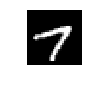

Its correspondent label:
tensor(7)


In [7]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

# MNIST-M Dataset

In [8]:
from my_dataset import MNIST_M

In [9]:
batch_size = 128
root_dir = "./data/"

transform_m = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4581609321206303, 0.462350402961343, 0.4084781187671726), (1, 1, 1))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_m = MNIST_M(root_dir, train=True, transform=transform_m, download=True)
trainloader_m = torch.utils.data.DataLoader(trainset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_m = MNIST_M(root_dir, train=False, transform=transform_m, download=True)
testloader_m = torch.utils.data.DataLoader(testset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 82th image in the first 128 images in the training set:


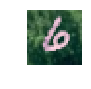

Its correspondent label:
tensor(6)


In [10]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader_m):
    inputs, labels = data
    break
    
idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Visualization

In [11]:
from sklearn import manifold

def extract_features(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, f, l = model(inputs)
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

def visualize_single_dataset(data, labels, perplexity=50, sample_num=None):
    total_num = labels.shape[0]
    if sample_num:
        idx = np.random.choice(total_num, sample_num, replace=False)
        data, labels = data[idx, :], labels[idx]
        total_num = sample_num
    tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    colors = ["red", "orange", "goldenrod", "yellow", "yellowgreen", "green", "teal", "blue", "violet", "purple"]
    for i in range(10):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], alpha=0.4)
    plt.axis("off")
    
def visualize_da(source, target, perplexity=50, sample_num=None, save=None):
    source_num = source.shape[0]
    target_num = target.shape[0]
    if sample_num:
        source, target = source[:sample_num, :], target[:sample_num, :]
        
    data = np.vstack((source, target))

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    plt.scatter(X[:sample_num, 0], X[:sample_num, 1], c="blue", edgecolors=None, alpha=0.4)
    plt.scatter(X[sample_num:, 0], X[sample_num:, 1], c="red", edgecolors=None, alpha=0.4)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()
    plt.clf()
    plt.close()

# Unsupervised Domain Adaptation

## Structure (GRL)

![MNIST Structure](https://c1.staticflickr.com/1/978/41270649404_41480327ce_o.png)

In [12]:
from my_dataset import ST_Dataset

In [13]:
batch_size = 128

trainset_da = ST_Dataset(trainset, trainset_m, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 112th image in the first 128 images in the training set:


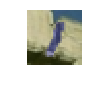

Its correspondent label:
I don't know :)

From domain:
Target


In [14]:
# randomly plot a sample from test set

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

In [15]:
class label_classifier(nn.Module):
    
    def __init__(self):
        super(label_classifier, self).__init__()
        
        # feature extractor
        self.C1 = nn.Conv2d(3, 32, 5)
        self.C2 = nn.Conv2d(32, 48, 5)
        # label classifier
        self.LC_FC1 = nn.Linear(48 * 4 * 4, 100)
        self.LC_FC2 = nn.Linear(100, 100)
        self.LC_FC3 = nn.Linear(100, 10)

        self.C1.weight.data.normal_(0.0, 0.1)
        self.C1.weight.data.normal_(0.0, 0.1)        
        self.LC_FC1.weight.data.normal_(0.0, 0.1)
        self.LC_FC2.weight.data.normal_(0.0, 0.1)
        self.LC_FC3.weight.data.normal_(0.0, 0.1)
        
        self.LC_FC1.bias.data.normal_(0.0, 0.1)
        self.LC_FC2.bias.data.normal_(0.0, 0.1)
        self.LC_FC3.bias.data.normal_(0.0, 0.1)
    def forward(self, x):
        
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2))
        # x's size is (128, 48, 4, 4)
        # flatten
        x = x.view(-1, 48 * 4 * 4)        
        f = x
        
        
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(x))
        # LC_FC2
        x_l = F.relu(self.LC_FC2(x_l))
        # LC_FC3
        x_l = self.LC_FC3(x_l)

        return x_l, f
    


In [16]:
class discriminator(nn.Module):
    
    def __init__(self):
        super(discriminator, self).__init__()
        # domain classifier
        self.DC_FC1 = nn.Linear(48 * 4 * 4, 100)
        self.DC_FC2 = nn.Linear(100, 100)
        self.DC_FC3 = nn.Linear(100, 10)
        self.DC_FC4 = nn.Linear(10, 1)
        
        self.DC_FC1.weight.data.normal_(0.0, 0.1)
        self.DC_FC2.weight.data.normal_(0.0, 0.1)
        self.DC_FC3.weight.data.normal_(0.0, 0.1)
        self.DC_FC4.weight.data.normal_(0.0, 0.1)
        
        self.DC_FC1.bias.data.normal_(0.0, 0.1)
        self.DC_FC2.bias.data.normal_(0.0, 0.1)
        self.DC_FC3.bias.data.normal_(0.0, 0.1)
        self.DC_FC4.bias.data.normal_(0.0, 0.1)
        
    def forward(self, x):
        
        # discriminator classifier
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x))
        # DC_FC2
        x_d = F.relu(self.DC_FC2(x_d))
        # DC_FC3
        x_d = F.relu(self.DC_FC3(x_d))
        # DC_FC4
        x_d = F.sigmoid(self.DC_FC4(x_d))
        
        return x_d
    


In [17]:
def extract_features_da(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, _, f, l = model(inputs)
        
        # from source
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        # from target
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

### Optimizer

In [54]:
LC = label_classifier()
if (use_gpu):
    LC.cuda()
print(LC)

label_classifier(
  (C1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (LC_FC1): Linear(in_features=768, out_features=100, bias=True)
  (LC_FC2): Linear(in_features=100, out_features=100, bias=True)
  (LC_FC3): Linear(in_features=100, out_features=10, bias=True)
)


In [55]:
DC = discriminator()
if (use_gpu):
    DC.cuda()
print(DC)

discriminator(
  (DC_FC1): Linear(in_features=768, out_features=100, bias=True)
  (DC_FC2): Linear(in_features=100, out_features=100, bias=True)
  (DC_FC3): Linear(in_features=100, out_features=10, bias=True)
  (DC_FC4): Linear(in_features=10, out_features=1, bias=True)
)


In [56]:
from math import exp

lr_init = 0.001
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()

optimizer_LC = optim.SGD(LC.parameters(), lr=lr_init, momentum=0.9)


optimizer_DC = optim.SGD(DC.parameters(), lr=lr_init, momentum=0.9)


def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

In [57]:
para_file_da_dc = "./parameters/DA_GAN_DC.pt"
para_file_da_lc = "./parameters/DA_GAN_LC.pt"
load_model_da_dc = os.path.isfile(para_file_da_dc)
load_model_da_lc = os.path.isfile(para_file_da_lc)
print("load_model_da = " + str(load_model_da_dc))
print("load_model_da = " + str(load_model_da_lc))

load_model_da = True
load_model_da = True


In [58]:
#%%skip (not $load_model_da_dc)
#DC.load_state_dict(torch.load(para_file_da_dc))
#%%skip (not $load_model_da_lc)
#LC.load_state_dict(torch.load(para_file_da_lc))

### Training process

In [ ]:
#%%skip $load_model_da_dc


total_epoch = 25
lamda = 2
const = 1000

for epoch in range(total_epoch):
    p = epoch * 1.0 / total_epoch
    
    DC.train()
    LC.eval()

    
    prev_loss_DC = np.float("inf")
    for DC_iter in range(10):
        epoch_loss_DC = 0.0
        running_loss_DC = 0.0
        for batch_idx, data in enumerate(trainloader_da):

            
            # get inputs
            source_size = data[0].size()[0] // 2
            inputs, labels, domains = data

            domains = domains.to(torch.float32)
            if (use_gpu):
                inputs, domains = inputs.cuda(), domains.cuda()
            inputs, domains = Variable(inputs), Variable(domains)

            # forward
            optimizer_LC.zero_grad()
            _, all_features = LC(inputs)

            source_feature = all_features[:source_size]
            source_domain = domains[:source_size]

            target_feature = all_features[-source_size:]
            target_domain = domains[-source_size:]
            optimizer_DC.zero_grad()
            pred_source_domains = DC(Variable(source_feature))
            pred_target_domains = DC(Variable(target_feature))

            loss_DC_source = const*criterion_DC(pred_source_domains, source_domain)/batch_size
            loss_DC_target = const*criterion_DC(pred_target_domains, target_domain)/batch_size
            
            
            loss_DC = loss_DC_source + loss_DC_target

            loss_DC.backward()
            optimizer_DC.step()

            # stat
            epoch_loss_DC += loss_DC.item()
            running_loss_DC += loss_DC.item()
            #print(loss_DC.cpu().data.numpy())
            # stat
            if batch_idx % 50 == 49:    # print every 50 mini-batches
                 print('[%3d] batch loss: %.3f' %
                  (batch_idx + 1, running_loss_DC / 50))
            running_loss_DC = 0.0
                
        print("DC epoch %d loss: %.3f -> %.3f\n" % (DC_iter + 1, prev_loss_DC, epoch_loss_DC))
        if prev_loss_DC - epoch_loss_DC < 0.1:
            prev_loss_DC = epoch_loss_DC
            pass
        else:
            prev_loss_DC = epoch_loss_DC                
    
    
    DC.eval()
    LC.train()
    adjust_lr(optimizer_LC, p)
    prev_loss_LC = np.float("inf")
    for LC_iter in range(10):
        epoch_loss_LC = 0.0
        running_loss_LC = 0.0
        for batch_idx, data in enumerate(trainloader_da):

            # get inputs
            source_size = data[0].size()[0] // 2

            inputs, labels, domains = data

            domains = domains.to(torch.float32)
            if (use_gpu):
                inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
            inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)

            optimizer_LC.zero_grad()
            # forward
            pred_labels, all_features = LC(inputs)

            src_label = pred_labels[:source_size]
            source_feature = all_features[:source_size]
            source_domain = domains[:source_size]

            target_feature = all_features[-source_size:]
            target_domain = domains[-source_size:]

            pred_source_domains = DC(source_feature)
            pred_target_domains = DC(target_feature)

            loss_LC = const*criterion_LC(all_features[:source_size], labels[:source_size])/batch_size
            loss_DC_source = const*criterion_DC(pred_source_domains, source_domain)/batch_size
            loss_DC_target = const*criterion_DC(pred_target_domains, source_domain)/batch_size

            loss = lamda*loss_LC + loss_DC_target + loss_DC_source 
            loss.backward()
            optimizer_LC.step()

            # stat
            epoch_loss_LC += loss.item()
            running_loss_LC += loss.item()

            if batch_idx % 50 == 49:    # print every 50 mini-batches
                print('[%3d] batch loss: %.3f' %
                      (batch_idx + 1, running_loss_LC / 50))
                running_loss_LC = 0.0     

        print("LC epoch %d loss: %.3f -> %.3f\n" % (LC_iter + 1, prev_loss_LC, epoch_loss_LC))
        if prev_loss_LC - epoch_loss_LC < 0.1:
            prev_loss_LC = epoch_loss_LC
            pass
        else:
            prev_loss_LC = epoch_loss_LC            
            

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[ 50] batch loss: 0.076
[100] batch loss: 0.029
[150] batch loss: 0.017
[200] batch loss: 0.024
[250] batch loss: 0.024
[300] batch loss: 0.007
[350] batch loss: 0.016
[400] batch loss: 0.003
[450] batch loss: 0.043
[500] batch loss: 0.006
[550] batch loss: 0.007
[600] batch loss: 0.011
[650] batch loss: 0.004
[700] batch loss: 0.014
[750] batch loss: 0.009
[800] batch loss: 0.005
[850] batch loss: 0.041
[900] batch loss: 0.006


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


DC epoch 1 loss: inf -> 1138.700

[ 50] batch loss: 0.007
[100] batch loss: 0.001
[150] batch loss: 0.002
[200] batch loss: 0.012
[250] batch loss: 0.008
[300] batch loss: 0.013
[350] batch loss: 0.005
[400] batch loss: 0.000
[450] batch loss: 0.006
[500] batch loss: 0.002
[550] batch loss: 0.003
[600] batch loss: 0.007
[650] batch loss: 0.003
[700] batch loss: 0.011
[750] batch loss: 0.001
[800] batch loss: 0.008
[850] batch loss: 0.001
[900] batch loss: 0.003
DC epoch 2 loss: 1138.700 -> 352.508

[ 50] batch loss: 0.005
[100] batch loss: 0.000
[150] batch loss: 0.002
[200] batch loss: 0.010
[250] batch loss: 0.010
[300] batch loss: 0.001
[350] batch loss: 0.003
[400] batch loss: 0.000
[450] batch loss: 0.012
[500] batch loss: 0.001
[550] batch loss: 0.005
[600] batch loss: 0.006
[650] batch loss: 0.002
[700] batch loss: 0.008
[750] batch loss: 0.002
[800] batch loss: 0.006
[850] batch loss: 0.000
[900] batch loss: 0.000
DC epoch 3 loss: 352.508 -> 258.775

[ 50] batch loss: 0.001
[10

[100] batch loss: 17.206
[150] batch loss: 18.147
[200] batch loss: 17.019
[250] batch loss: 19.563
[300] batch loss: 17.560
[350] batch loss: 17.904
[400] batch loss: 18.293
[450] batch loss: 17.596
[500] batch loss: 18.476
[550] batch loss: 17.896
[600] batch loss: 18.503
[650] batch loss: 18.434
[700] batch loss: 16.897
[750] batch loss: 18.440
[800] batch loss: 18.906
[850] batch loss: 17.458
[900] batch loss: 16.245
LC epoch 1 loss: 16756.102 -> 16433.176

[ 50] batch loss: 17.111
[100] batch loss: 17.242
[150] batch loss: 18.134
[200] batch loss: 16.983
[250] batch loss: 19.282
[300] batch loss: 17.305
[350] batch loss: 17.525
[400] batch loss: 17.939
[450] batch loss: 17.301
[500] batch loss: 18.190
[550] batch loss: 17.823
[600] batch loss: 18.154
[650] batch loss: 18.188
[700] batch loss: 16.895
[750] batch loss: 18.297
[800] batch loss: 18.739
[850] batch loss: 17.229
[900] batch loss: 16.072
LC epoch 1 loss: 16433.176 -> 16253.101

[ 50] batch loss: 4.317
[100] batch loss: 4

[150] batch loss: 16.954
[200] batch loss: 15.854
[250] batch loss: 18.063
[300] batch loss: 16.657
[350] batch loss: 16.572
[400] batch loss: 16.880
[450] batch loss: 16.230
[500] batch loss: 16.967
[550] batch loss: 16.637
[600] batch loss: 16.915
[650] batch loss: 17.421
[700] batch loss: 16.098
[750] batch loss: 17.282
[800] batch loss: 17.568
[850] batch loss: 16.469
[900] batch loss: 15.299
LC epoch 2 loss: 15354.283 -> 15299.618

[ 50] batch loss: 15.834
[100] batch loss: 16.040
[150] batch loss: 16.896
[200] batch loss: 15.689
[250] batch loss: 18.028
[300] batch loss: 16.619
[350] batch loss: 16.440
[400] batch loss: 17.037
[450] batch loss: 16.392
[500] batch loss: 16.936
[550] batch loss: 16.724
[600] batch loss: 16.940
[650] batch loss: 17.414
[700] batch loss: 16.103
[750] batch loss: 17.226
[800] batch loss: 17.465
[850] batch loss: 16.369
[900] batch loss: 15.109
LC epoch 2 loss: 15299.618 -> 15275.083

[ 50] batch loss: 15.712
[100] batch loss: 16.056
[150] batch loss: 

[200] batch loss: 15.225
[250] batch loss: 17.537
[300] batch loss: 16.181
[350] batch loss: 15.521
[400] batch loss: 16.043
[450] batch loss: 15.929
[500] batch loss: 16.615
[550] batch loss: 16.240
[600] batch loss: 16.248
[650] batch loss: 16.624
[700] batch loss: 15.415
[750] batch loss: 16.799
[800] batch loss: 17.145
[850] batch loss: 15.708
[900] batch loss: 14.712
LC epoch 3 loss: 14792.962 -> 14770.654

[ 50] batch loss: 15.143
[100] batch loss: 15.636
[150] batch loss: 16.481
[200] batch loss: 15.303
[250] batch loss: 17.379
[300] batch loss: 16.139
[350] batch loss: 15.366
[400] batch loss: 16.043
[450] batch loss: 15.884
[500] batch loss: 16.628
[550] batch loss: 16.320
[600] batch loss: 16.203
[650] batch loss: 16.627
[700] batch loss: 15.342
[750] batch loss: 16.710
[800] batch loss: 16.969
[850] batch loss: 15.656
[900] batch loss: 14.784
LC epoch 3 loss: 14770.654 -> 14732.778

[ 50] batch loss: 15.121
[100] batch loss: 15.633
[150] batch loss: 16.436
[200] batch loss: 

In [ ]:
torch.save(DC.state_dict(), para_file_da_dc)
torch.save(LC.state_dict(), para_file_da_lc)

### Test on MNIST and MNIST-M dataset

In [ ]:
def evaluate_da_accuracy(model_LC, model_DC ,dataloader, source):
    model_LC.eval()
    model_DC.eval()
    correct_LC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs, volatile = True), Variable(labels, volatile = True)
            
            #print(inputs.shape)
            #print(labels.shape)
            
            outputs_LC, _ = model_LC(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()

            total += labels.size()[0]
        acc_LC = correct_LC / total
    return acc_LC

In [ ]:
print("Label classifier accuracy on MNIST test set (DA): %f"
      %evaluate_da_accuracy(LC, DC, testloader, source=True))

In [ ]:
print("Label classifier accuracy on MNIST-M test set (DA): %f\n"
      %evaluate_da_accuracy(LC, DC, testloader_m, source=True))

### Visualization

In [ ]:
f_da, lh_da, l_da = extract_features_da(cnn_da, testloader)
f_m_da, lh_m_da, l_m_da = extract_features_da(cnn_da, testloader_m)

Features of MNIST test set (extracted by DA model)

In [ ]:
visualize_da(f_da.numpy(), f_m_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_features_Adapted.svg")

Features of MNIST-M test set (extracted by DA model)

In [ ]:
visualize_da(lh_da.numpy(), lh_m_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_lasthidden_Adapted.svg")